<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación </h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
<h2>Mentoría: Detección de objetos en imágenes</h2>
</center>


En la siguiente notebook, incorporaremos parte de lo realizado en las entregas 1 de los grupos de estudiantes: 

* [Grupo 1](https://github.com/Ana1890/Deteccion-de-objetos-en-imagenes) : Ana Rusconi, Ignacio Grosso y  Mariano Lucero

* [Grupo 2](https://github.com/leorodriguez/mentoria-diplodatos-grupo2):  Diego Gonzalez, Florencia Caballero, Joel Vivas y Leonardo Rodriguez


#### <a name="generacion_tabla"></a>
#### **Análisis general del dataset**

En las entregas anteriores tuvieron la oportunidad de explorar una pequeña muestra de las imágenes para que el análisis sea mas representativo del conjunto de datos total, en esta entrega utilizaremos el dataset completo.

En esta notebook utilizaremos la tabla generada en'[5-Generación_de_fotos_recortadas_y_tabla-Aprendizaje_Supervisado](https://colab.research.google.com/drive/1fgB4F4DlBqkCvOatqo3whm4ZTPsiP0L7?usp=sharing)'

La carpeta con los datos, es compartida en el [Drive](https://drive.google.com/drive/folders/1-bl3h1g1WROMmz66A2h7t2n3leTjhYxH?usp=sharing) y en el desarrollo de esta entrega con las consignas, se utilizará la misma en el entorno de Colab, pero también estarán en el repositorio de Github de la mentoría, en la [carpeta del práctico](https://github.com/luciabarg/mentoria_img/tree/master/4-Aprendizaje%20Supervisado).

La siguiente notebook usa como entorno Colab:

In [1]:
#vinculamos el Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# librerías necesarias 
import os
from IPython.display import Image as Imge
import pandas as pd
import numpy as np
import glob

#seguimos agregando librerías necesarias:
#las que no tengan, vayan instalándolas
import cv2
import numpy as np

import matplotlib.pyplot as plt
import PIL
from PIL import Image
from os import path

from google.colab.patches import cv2_imshow #en Colab!

import seaborn as sns

import re

import json


from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error


Para que se hagan una idea de la cantidad de datos que deberíamos analizar, los exploramos y visualizamos con una tabla:

In [3]:
#nos posicionamos en la carpeta con los datos
os.chdir('/content/drive/My Drive/Mentoria/crop')
#listamos solo las carpetas
! ls -d */
! ls -d */*/

Amarillos/  Mano-Amarillo/  Manos/  Mano-Verde/  Verdes/
Mano-Amarillo/Amarillo/  Mano-Verde/Mano/
Mano-Amarillo/Mano/	 Mano-Verde/Verde/


#### <a name="generacion_tabla"></a>
#### **Análisis general de la tabla**

1.   Cuántas fotos originales hay? (no filas! fotos :) )
2.   Separar los tamaños 'P' y 'G'. Tratarlos como conjuntos de datos por separado. 
      


In [4]:
#leemos el archivo de la tabla:
df = pd.read_csv('csv_wlabels_all_df.csv', index_col=0)
df = df.drop(['Type'], axis=1)  #la eliminamos ya que es una división previa de los datos, que no utilizaremos en este caso.
print(df.shape)
df.head()

(15197, 2060)


,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Amarillos_0_double_box1.jpg,218,461,464,715,M,G,243,251,60993,si,Amarillo,0.740974,1.066019,0.132695,0.224892,0.140456,0.129134,0.201447,1.076733,0.461108,0.299800,0.457940,0.201904,0.569677,0.737381,0.480929,0.200076,0.018410,0.674050,0.028826,0.005310,0.128693,0.592353,0.138541,0.141684,0.363294,0.264674,0.519292,0.292655,...,0.463567,0.091676,0.300955,0.696112,2.409413,0.536980,0.102273,0.157441,0.165093,1.067619,0.751934,0.231443,0.487437,0.446320,0.822407,0.527523,0.217110,0.489194,1.535306,0.521390,0.599480,0.201182,0.391337,0.040206,1.347440,0.448389,0.462778,0.590751,0.877142,0.009986,0.939221,0.859877,0.981910,0.356366,1.748501,0.288037,0.079172,0.266234,0.078312,0.421612
1,M_G_Mostrando_Amarillos_0_double_box2.jpg,617,865,432,598,M,G,248,166,41168,si,Amarillo,1.621832,0.208859,0.627041,0.061717,0.052486,0.064176,0.479256,1.068516,0.509059,0.207385,0.218195,0.169190,0.695486,0.237641,0.146711,0.126334,0.029900,0.148363,0.126833,0.181351,0.044585,0.447270,0.134360,0.113650,1.153900,0.653832,0.041024,0.543086,...,0.816892,0.027489,0.183116,0.626535,1.734605,0.672962,0.030057,0.101685,0.295544,0.392251,0.874054,0.105285,0.110713,0.421417,1.335695,0.500971,1.139208,0.110803,0.850265,0.618181,0.077352,0.376629,0.319234,0.783792,0.427963,0.133063,0.064981,0.017857,0.320706,0.219192,1.199712,0.808466,0.491182,0.356616,0.812572,0.481357,0.071471,0.572322,0.052072,0.213453
2,M_G_Mostrando_Amarillos_100_double_box1.jpg,831,1138,256,408,M,G,307,152,46664,si,Amarillo,1.029100,0.246964,0.825601,0.460009,0.467037,0.339540,0.653041,1.324649,0.890402,0.488183,0.639772,0.085819,0.928661,0.148958,0.066155,0.125391,0.191808,0.506981,0.257565,0.073959,0.115524,0.552251,0.764911,0.047104,0.207601,0.126297,0.286010,0.733891,...,0.367434,0.436251,0.000000,0.863331,0.112969,0.902164,0.040710,0.467132,0.242757,0.853286,0.677067,0.300664,0.587456,0.112658,1.077973,0.144736,0.294853,0.065939,0.708062,1.192815,0.317312,0.421216,0.425882,1.091190,0.595093,0.138662,0.045023,0.543350,0.155850,0.305535,0.463963,0.355296,0.360880,0.322859,0.917611,0.408334,0.733588,0.416891,0.151471,0.045931
3,M_G_Mostrando_Amarillos_100_double_box2.jpg,511,812,8,228,M,G,301,220,66220,si,Amarillo,0.086092,0.455828,0.418580,0.131673,0.437982,0.424093,0.350489,1.974670,0.183887,0.241193,0.046988,0.312450,0.497026,0.135973,0.195146,0.010869,0.109539,0.234128,0.235778,0.108441,0.054660,0.327069,0.439913,0.050670,0.159292,0.159228,0.311495,0.999218,...,0.625021,0.219692,0.029219,0.496582,1.540741,2.338270,0.039844,0.174714,0.383931,0.449525,0.104648,0.205243,0.104140,0.109657,1.092486,0.087052,0.451129,0.034648,0.272219,0.209507,0.138235,0.193764,0.081227,1.006930,1.506502,0.044992,1.047619,0.605296,0.391379,0.164156,0.325708,0.028549,0.225465,0.325055,0.460382,0.127341,0.140412,0.157423,0.296102,0.023314
4,M_G_Mostrando_Amarillos_101_double_box1.jpg,668,988,0,222,M,G,320,222,71040,si,Amarillo,0.068881,0.185060,0.427007,0.637546,0.357156,0.125816,0.450526,1.246901,0.236921,0.393104,0.632759,0.413947,0.119917,0.192305,0.372677,0.075668,0.103642,0.165934,0.239047,0.054987,0.129182,0.178563,0.217686,0.130172,0.080214,0.346873,0.392784,1.042759,...,0.205059,0.225329,0.062677,0.558553,1.780167,1.919532,0.165511,0.649451,0.168220,0.127490,0.310012,0.071468,0.196005,0.042177,1.261848,0.216220,0.501204,0.194764,0.183244,0.426975,0.477355,0.349516,0.131819,0.489718,0.981365,0.049099,0.471963,0.190929,0.413278,0.175050,0.523058,0.028629,0.076427,0.462088,0.694069,0.060703,0.065414,0.296513,0.368063,0.039469


In [5]:
feature_cols = [col for col in df.columns[12:]]
categ_cols=['Time', 'Size', 'guantes','color']
size_cols = ['Hand_Pixel_Width', 'Hand_Pixel_Height', 'Area']

* Exploramos la tabla inicial

In [6]:
df.describe(include='object')

,filename,Time,Size,guantes,color
count,15197,15197,15197,15197,15197
unique,15197,3,2,2,3
top,T_P_Mostrando_Mano-Verde_49_double_box1.jpg,M,G,si,mano
freq,1,5439,7790,9252,5945


In [7]:
#Nos fijamos si hay duplicados tanto en el nombre como en el índice
df[df.filename.duplicated()]

,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047


In [8]:
df[df.index.duplicated()]

,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047


No hay filas duplicadas.

In [9]:
# Nos fijamos si existen valores nulos
print("Columnas con algún valor nulo:",df.columns[df.isna().any()])

Columnas con algún valor nulo: Index([], dtype='object')


<br>

### Calculamos la cantidad de imágenes originales

#### Obtenemos los nombres de las imágenes usando el filename (eliminando la sección de box correspondiente a la selección de cada mano o guante)

In [10]:
#formato genérico del tipo de archivo
#filename pattern: Time_Size_Action_Color_Number_Box.Extension

# Nos quedamos sin la parte del box, que corresponde a la selección de manos y guantes dentro de la imagen.

original_filenames=df.filename.apply(lambda x: "_".join(x.split("_", 5)[:5])+".jpg")
original_filenames.drop_duplicates(keep='first', inplace=True)
original_filenames=original_filenames.sort_values(ignore_index=True)

print("Cantidad de imágenes originales (obtenidas del datafame):",len(original_filenames),"\n")
original_filenames

Cantidad de imágenes originales (obtenidas del datafame): 8509 



0         M_G_Mostrando_Amarillos_0.jpg
1         M_G_Mostrando_Amarillos_1.jpg
2        M_G_Mostrando_Amarillos_10.jpg
3       M_G_Mostrando_Amarillos_100.jpg
4       M_G_Mostrando_Amarillos_101.jpg
                     ...               
8504       T_P_Trabajando_Verdes_95.jpg
8505       T_P_Trabajando_Verdes_96.jpg
8506       T_P_Trabajando_Verdes_97.jpg
8507       T_P_Trabajando_Verdes_98.jpg
8508       T_P_Trabajando_Verdes_99.jpg
Name: filename, Length: 8509, dtype: object

* Separación en imágenes chicas y grandes

In [11]:
df_pequeño=df[df.Size=='G']
df_grande=df[df.Size=='P']


Preguntas antes de entrenar los algoritmos:

*   Identifique las clases y cuántas hay de cada una (tanto binaria como multiclase). Hay desbalanceo? Si lo hubiera, cómo lo solucionarían? 

*   Un par de preguntas con respecto la separación de los datos:
     
     * Qué se hace con las columnas *'target'*? ('guantes' y 'color'). Hay columnas que pueden ser descartadas? Si quisiéramos aprovechar la información de las columnas descartadas, como podríamos hacerlo? 
    
* Para la variable target elegida, conviene dejarla así o hay que hacer alguna transformación?
* Conviene normalizar antes de pasar los datos al algoritmo?

In [12]:
#Dimensiones de los dataset
[df_pequeño.shape, df_grande.shape]

[(7790, 2060), (7407, 2060)]

In [13]:
df_pequeño.describe(include='object')

,filename,Time,Size,guantes,color
count,7790,7790,7790,7790,7790
unique,7790,3,1,2,3
top,T_G_Mostrando_Manos_144_double_box2.jpg,M,G,si,mano
freq,1,2833,7790,4615,3175


In [14]:
df_pequeño.groupby(by=['guantes']).size()

guantes
no    3175
si    4615
dtype: int64

In [15]:
df_pequeño.groupby(by=['color']).size()

color
Amarillo    2399
Verde       2216
mano        3175
dtype: int64

In [16]:
df_pequeño.groupby(by=['guantes','color']).size()

guantes  color   
no       mano        3175
si       Amarillo    2399
         Verde       2216
dtype: int64

In [17]:
df_grande.groupby(by='guantes').size()

guantes
no    2770
si    4637
dtype: int64

In [18]:
df_grande.groupby(by='color').size()

color
Amarillo    2293
Verde       2344
mano        2770
dtype: int64

In [19]:
df_grande.groupby(by=['guantes', 'color']).size()

guantes  color   
no       mano        2770
si       Amarillo    2293
         Verde       2344
dtype: int64

* Podemos ver que en ambos grupos los datos no se encuentran desbalanceados en lo que respecta a las clases de 'guantes' y/o 'guantes'. Sin embargo, si hubiera aparecido un desbalanceo entre los datos se podría agregar con técnicas de aumentación de datos más datos que representen a la clase que está desbalanceada. También podríamos aportarle más peso a esta clase cuando definamos nuestros modelos de predicción.

* Podríamos descartar del dataset aquellas columnas que no son el target. Sin embargo, podemos realizar una exploración del comportamiento entre estas etiquetas y otras columnas categróricas para poder detectar si nos pueden aportar más información. Por ejemplo, el área nos podría indicar qué tan grandes son nuestros objetos, y por lo tanto está relacionada con la característica de Size, independientemente si hay guantes o no, aunque el tamaño nos puede indicar si será difícil o no predecir. 

* La variable target conviene codificarla a un número entero, puesto que de esta manera es como indentifican los modelos al target. Algunos modelos de clasificación necesitan que los datos de entrada se encuentren en un determinado tipo de dato, y otros requieren o suponen que las variables tienen una media de 0. Por lo tanto conviene normalizar los datos antes de que se ingresen a los modelos de clasificación.

### Entrenamiento de algoritmos para generar un modelo:

* Separar los datos 'P' y 'G' en conjuntos de test y entrenamiento en un 70-30. Recordar que tenemos para hacer tanto clasificación binaria como multiclase.

* Entrenar los algoritmos de clasificación KNN, SMV y Random Forest:
  * Entrenar el modelo sin parámetros y tomarlo como baseline. Revisar documentación para identificar los parámetros correspondientes.
  * Utilizar CV para encontrar los parámetros para encontrar el mejor modelo de cada uno de ellos. (Cuál métrica van a utilizar? Porqué eligen esa en particular? Se puede utilizar la misma métrica para toda clase de datos? )
  * Hacer una tabla para comparar los mejores modelos de cada algoritmo. 
  * Visualizar los resultados por medio de:
    *  Matriz de Confusión
    *  Reporte de Clasificación
  * Recordar de documentar los pasos que están llevando a cabo, comentar el código, plantear inconvenientes y contar lo que encontraron, poner conclusiones :).
  
  Opcional: 
  * Graficar la métrica elegida con respecto al cambio de los parámetros de los conjuntos 'test' y 'train'.
  * Generar las Curvas de ROC correspondientes para los mejores modelos de clasificación binaria.
  * Podemos utilizar los mejores modelos para generar uno mas mejor? :P
  (chusmear: ['Ensembles'](https://www.iartificial.net/ensembles-voting-bagging-boosting-stacking/) )

## Imágenes pequeñas

In [20]:
from sklearn import preprocessing

#Codificación de nuestro target
df_pequeño_cod=df_pequeño.copy()
df_pequeño_cod['guantes']=preprocessing.LabelEncoder() .fit_transform(df_pequeño['guantes'])
df_pequeño_cod['color']=preprocessing.LabelEncoder() .fit_transform(df_pequeño['color'])
df_pequeño_cod.head()

,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Amarillos_0_double_box1.jpg,218,461,464,715,M,G,243,251,60993,1,0,0.740974,1.066019,0.132695,0.224892,0.140456,0.129134,0.201447,1.076733,0.461108,0.299800,0.457940,0.201904,0.569677,0.737381,0.480929,0.200076,0.018410,0.674050,0.028826,0.005310,0.128693,0.592353,0.138541,0.141684,0.363294,0.264674,0.519292,0.292655,...,0.463567,0.091676,0.300955,0.696112,2.409413,0.536980,0.102273,0.157441,0.165093,1.067619,0.751934,0.231443,0.487437,0.446320,0.822407,0.527523,0.217110,0.489194,1.535306,0.521390,0.599480,0.201182,0.391337,0.040206,1.347440,0.448389,0.462778,0.590751,0.877142,0.009986,0.939221,0.859877,0.981910,0.356366,1.748501,0.288037,0.079172,0.266234,0.078312,0.421612
1,M_G_Mostrando_Amarillos_0_double_box2.jpg,617,865,432,598,M,G,248,166,41168,1,0,1.621832,0.208859,0.627041,0.061717,0.052486,0.064176,0.479256,1.068516,0.509059,0.207385,0.218195,0.169190,0.695486,0.237641,0.146711,0.126334,0.029900,0.148363,0.126833,0.181351,0.044585,0.447270,0.134360,0.113650,1.153900,0.653832,0.041024,0.543086,...,0.816892,0.027489,0.183116,0.626535,1.734605,0.672962,0.030057,0.101685,0.295544,0.392251,0.874054,0.105285,0.110713,0.421417,1.335695,0.500971,1.139208,0.110803,0.850265,0.618181,0.077352,0.376629,0.319234,0.783792,0.427963,0.133063,0.064981,0.017857,0.320706,0.219192,1.199712,0.808466,0.491182,0.356616,0.812572,0.481357,0.071471,0.572322,0.052072,0.213453
2,M_G_Mostrando_Amarillos_100_double_box1.jpg,831,1138,256,408,M,G,307,152,46664,1,0,1.029100,0.246964,0.825601,0.460009,0.467037,0.339540,0.653041,1.324649,0.890402,0.488183,0.639772,0.085819,0.928661,0.148958,0.066155,0.125391,0.191808,0.506981,0.257565,0.073959,0.115524,0.552251,0.764911,0.047104,0.207601,0.126297,0.286010,0.733891,...,0.367434,0.436251,0.000000,0.863331,0.112969,0.902164,0.040710,0.467132,0.242757,0.853286,0.677067,0.300664,0.587456,0.112658,1.077973,0.144736,0.294853,0.065939,0.708062,1.192815,0.317312,0.421216,0.425882,1.091190,0.595093,0.138662,0.045023,0.543350,0.155850,0.305535,0.463963,0.355296,0.360880,0.322859,0.917611,0.408334,0.733588,0.416891,0.151471,0.045931
3,M_G_Mostrando_Amarillos_100_double_box2.jpg,511,812,8,228,M,G,301,220,66220,1,0,0.086092,0.455828,0.418580,0.131673,0.437982,0.424093,0.350489,1.974670,0.183887,0.241193,0.046988,0.312450,0.497026,0.135973,0.195146,0.010869,0.109539,0.234128,0.235778,0.108441,0.054660,0.327069,0.439913,0.050670,0.159292,0.159228,0.311495,0.999218,...,0.625021,0.219692,0.029219,0.496582,1.540741,2.338270,0.039844,0.174714,0.383931,0.449525,0.104648,0.205243,0.104140,0.109657,1.092486,0.087052,0.451129,0.034648,0.272219,0.209507,0.138235,0.193764,0.081227,1.006930,1.506502,0.044992,1.047619,0.605296,0.391379,0.164156,0.325708,0.028549,0.225465,0.325055,0.460382,0.127341,0.140412,0.157423,0.296102,0.023314
4,M_G_Mostrando_Amarillos_101_double_box1.jpg,668,988,0,222,M,G,320,222,71040,1,0,0.068881,0.185060,0.427007,0.637546,0.357156,0.125816,0.450526,1.246901,0.236921,0.393104,0.632759,0.413947,0.119917,0.192305,0.372677,0.075668,0.103642,0.165934,0.239047,0.054987,0.129182,0.178563,0.217686,0.130172,0.080214,0.346873,0.392784,1.042759,...,0.205059,0.225329,0.062677,0.558553,1.780167,1.919532,0.165511,0.649451,0.168220,0.127490,0.310012,0.071468,0.196005,0.042177,1.261848,0.216220,0.501204,0.194764,0.183244,0.426975,0.477355,0.349516,0.131819,0.489718,0.981365,0.049099,0.471963,0.190929,0.413278,0.175050,0.523058,0.028629,0.076427,0.462088,0.694069,0.060703,0.065414,0.296513,0.368063,0.039469


In [21]:
feat_guantes_pequeño=['518', '1563']

In [22]:
var_pequeño_guantes=np.array(df_pequeño_cod[feat_guantes_pequeño])
var_pequeño_guantes_sc = preprocessing.StandardScaler().fit_transform(var_pequeño_guantes)

#Pasamos los datos a un dataframe
df_var_pequeño_guantes=pd.DataFrame(data=var_pequeño_guantes_sc, index=df_pequeño_cod.index, columns=feat_guantes_pequeño)
df_var_pequeño_guantes.head(3)

,518,1563
0,-0.883125,-0.869236
1,-0.787633,-0.954215
2,-0.250995,2.911226


In [23]:
# verificar de transformar lo de train a lo de test

In [24]:
df_pequeño_guantes=df_var_pequeño_guantes.copy()
df_pequeño_guantes['guantes']=df_pequeño_cod['guantes']
df_pequeño_guantes.head(3)

,518,1563,guantes
0,-0.883125,-0.869236,1
1,-0.787633,-0.954215,1
2,-0.250995,2.911226,1


In [25]:
df_pequeño_color=df_var_pequeño_guantes.copy()
df_pequeño_color['color']=df_pequeño_cod['color']
df_pequeño_color.head(3)

,518,1563,color
0,-0.883125,-0.869236,0
1,-0.787633,-0.954215,0
2,-0.250995,2.911226,0


In [26]:
#Vectorizacion
g_arr_pequeño=np.array(df_pequeño_guantes[feat_guantes_pequeño])
g_arr_pequeño.shape

(7790, 2)

In [27]:
arr_color=np.array(df_pequeño_color['color'])
arr_color.shape

(7790,)

In [28]:
#Etiquetas para clasificación binaria
arr_guantes=np.array(df_pequeño_guantes['guantes'])
arr_guantes_vect=arr_guantes.reshape(-1,1)
arr_guantes_vect.shape

(7790, 1)

## Clasificación binaria imágenes pequeñas



## KNN vecinos

In [29]:
#Separación de nuestros datos
X, y=g_arr_pequeño, arr_guantes
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

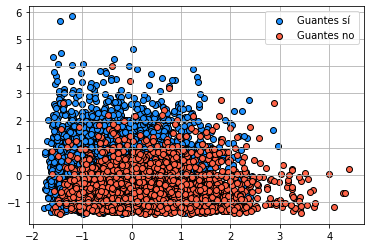

In [30]:
#Graficamos nuestro conjunto de datos
plt.scatter( X_train[:,0][y_train==1] , X_train[:,1][y_train==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_train[:,0][y_train==0] , X_train[:,1][y_train==0], color="tomato", edgecolors='k', label="Guantes no")
plt.grid()
plt.legend()
plt.show()

In [31]:
from sklearn.neighbors import KNeighborsClassifier
vecinos_1 = KNeighborsClassifier()
vecinos_1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
[vecinos_1.score(X_train,y_train), vecinos_1.score(X_test, y_test)]

[0.7907573812580231, 0.7120239623448866]

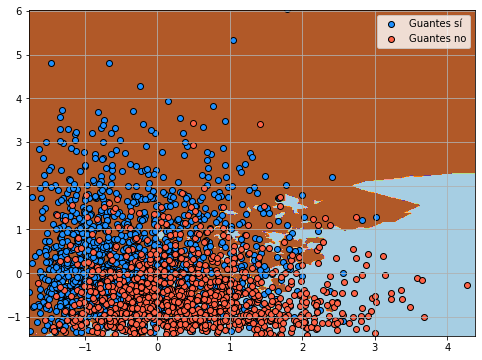

In [33]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = vecinos_1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

Nos fijamos si con algun otro 'K' el error cuadrático medio disminuye

In [34]:
#Ahora para varios k
train_errors = []
test_errors = []
sum_errors = []
vecinos = [1, 5,10,15,21, 35,40, 45, 50, 57,63,75,83]
for vecino in vecinos:
    # Entrenamiento:
    vecinos_1 = KNeighborsClassifier(n_neighbors=vecino)
    vecinos_1.fit(X_train, y_train)
    
    # Predicción:
    y_train_pred = vecinos_1.predict(X_train)
    y_test_pred = vecinos_1.predict(X_test)
    
    # Evaluación:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    sum_errors.append(train_error + test_error)

    #Viusalizamos el error que se produce con cada polinomio
    print(f'Con grado {vecino} en entrenamiento error: {train_error:0.2}, prueba: {test_error:0.2}, suma: {test_error+train_error:0.2}')

Con grado 1 en entrenamiento error: 0.0, prueba: 0.34, suma: 0.34
Con grado 5 en entrenamiento error: 0.21, prueba: 0.29, suma: 0.5
Con grado 10 en entrenamiento error: 0.24, prueba: 0.28, suma: 0.52
Con grado 15 en entrenamiento error: 0.23, prueba: 0.26, suma: 0.5
Con grado 21 en entrenamiento error: 0.24, prueba: 0.26, suma: 0.5
Con grado 35 en entrenamiento error: 0.25, prueba: 0.25, suma: 0.5
Con grado 40 en entrenamiento error: 0.25, prueba: 0.25, suma: 0.5
Con grado 45 en entrenamiento error: 0.25, prueba: 0.25, suma: 0.5
Con grado 50 en entrenamiento error: 0.25, prueba: 0.26, suma: 0.5
Con grado 57 en entrenamiento error: 0.25, prueba: 0.26, suma: 0.51
Con grado 63 en entrenamiento error: 0.25, prueba: 0.26, suma: 0.51
Con grado 75 en entrenamiento error: 0.25, prueba: 0.26, suma: 0.5
Con grado 83 en entrenamiento error: 0.25, prueba: 0.26, suma: 0.51


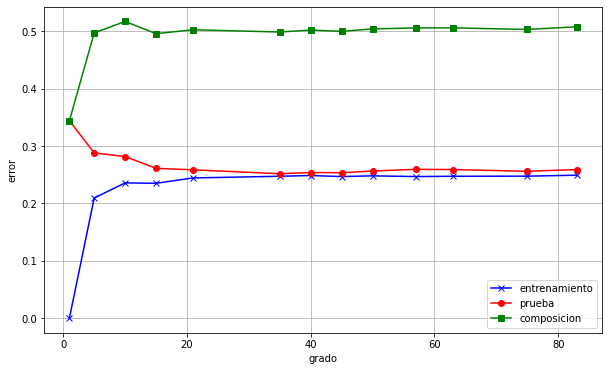

In [35]:
#Graficamos las curvas de error
plt.figure(figsize=(10,6))
plt.plot(vecinos, train_errors, '-x', color="blue", label="entrenamiento")
plt.plot(vecinos, test_errors, '-o', color="red", label="prueba")
plt.plot(vecinos, sum_errors, '-s', color="g", label="composicion")
plt.legend()
plt.xlabel("grado")
plt.ylabel("error")
plt.grid(True)
plt.show()

* Con k igual a 35 o 45 el error es el mismo para ambos conjuntos, por lo que nos quedamos con esa cantidad de vecinos cercanos para evaluar.

In [36]:
vecinos_1 = KNeighborsClassifier(n_neighbors=35)
vecinos_1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [37]:
[vecinos_1.score(X_train, y_train), vecinos_1.score(X_test, y_test)]

[0.752796625710618, 0.748395378690629]

Podemos ver que el overfitting disminuyó considerablemente

* Ahora con GridSearchCV

In [38]:
params_vecinos={
                'n_neighbors': [30,35,40,45,50,60,65], 
                'weights': ['uniform', 'distance'], 
                'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p':[1, 2],
                'metric':[ 'euclidean', 'minkowski', 'manhattan'],
                  
                }

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
vecinos_1 = KNeighborsClassifier()
cv = GridSearchCV(vecinos_1, params_vecinos, scoring='neg_mean_squared_error', cv=5)
cv.fit(X_train,y_train);

In [41]:
results = cv.cv_results_
df = pd.DataFrame(results)
cols_int=['params','mean_test_score', 'std_test_score','rank_test_score']
df[cols_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
138,"{'algorithm': 'ball_tree', 'metric': 'minkowsk...",-0.255453,0.009008,1
26,"{'algorithm': 'auto', 'metric': 'euclidean', '...",-0.255453,0.009008,1
278,"{'algorithm': 'brute', 'metric': 'euclidean', ...",-0.255453,0.009008,1


In [42]:
mejor_vecino=cv.best_estimator_
[mejor_vecino.score(X_train, y_train), mejor_vecino.score(X_test, y_test) ]

[0.7526132404181185, 0.7424047924689773]

In [43]:
mejor_vecino.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=65, p=1,
                     weights='uniform')>

In [44]:
#Predecimos con el nuevo modelo
y_best=mejor_vecino.predict(X_test)
y_train_best=mejor_vecino.predict(X_train)

#Evaluación
train_error = mean_squared_error(y_train, y_train_best)
test_error = mean_squared_error(y_test, y_best)
print(f'Error de entrenamiento: {train_error:0.2}')
print(f'Error en prueba: {test_error:0.2}')

Error de entrenamiento: 0.25
Error en prueba: 0.26


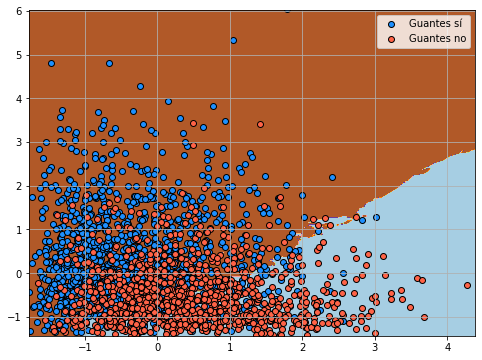

In [45]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_vecino.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

* **Matriz de confusión**

In [46]:
class_names=['guantes no','guantes sí']

Matriz de confusión del conjunto de test
[[ 608  369]
 [ 233 1127]]


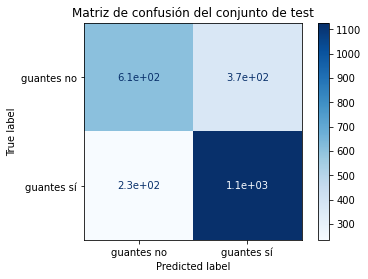

In [47]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(mejor_vecino, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Podemos ver que para el conjunto de test hay una gran cantidad de verdaderos positivos

Matriz de confusión del conjunto de entrenamiento
[[1372  826]
 [ 523 2732]]


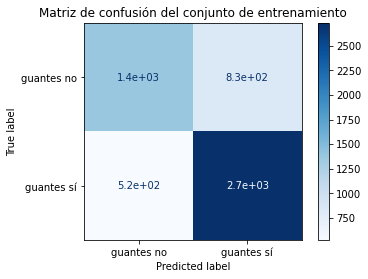

In [48]:
disp = plot_confusion_matrix(mejor_vecino, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Podemos ver que existe una gran cantidad de verdaderos positivos para el conjunto de entrenamiento

* **Reporte de clasificación**

In [49]:
from sklearn.metrics import classification_report

#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67      2198
           1       0.77      0.84      0.80      3255

    accuracy                           0.75      5453
   macro avg       0.75      0.73      0.74      5453
weighted avg       0.75      0.75      0.75      5453



In [50]:
#Reporte para el conjunto de prueba
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67       977
           1       0.75      0.83      0.79      1360

    accuracy                           0.74      2337
   macro avg       0.74      0.73      0.73      2337
weighted avg       0.74      0.74      0.74      2337



## SVM

In [51]:
import sklearn
from sklearn.svm import SVC

In [52]:
#Separación de nuestros datos
X, y=g_arr_pequeño, arr_guantes
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [53]:
[X_train.shape, y_train.shape]

[(5453, 2), (5453,)]

Sabemos que nuestros datos no son linealmente separables, por lo que no vamos a utilizar una linea recta para predecir. En cambio usamos la función que proviene de sklearn que permite ajustar ciertos kernels para tratar nuestro tipo de datos

In [54]:
svm1 = sklearn.svm.SVC(random_state=0)
svm1.fit(X_train, y_train);

In [55]:
svm1.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)>

In [56]:
[svm1.score(X_train,y_train), svm1.score(X_test, y_test)]

[0.7438107463781405, 0.7428326914848096]

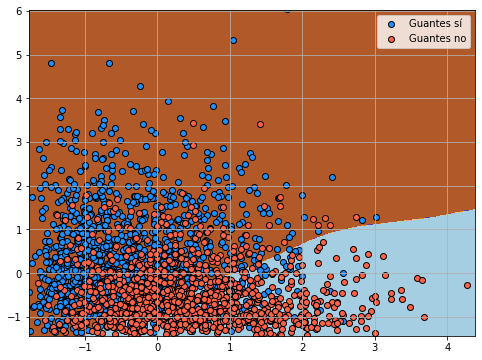

In [57]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = svm1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

* Ahora con GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV

In [59]:
param_grid = {
              'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']
              }

In [60]:
svm1 = sklearn.svm.SVC(random_state=0)
cv = GridSearchCV(svm1, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

In [61]:
results = cv.cv_results_
df = pd.DataFrame(results)
feat_int=['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
df[feat_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
16,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.744363,0.008023,1
21,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.744180,0.008271,2
17,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.744180,0.008163,3


In [62]:
mejor_svm1=cv.best_estimator_
[mejor_svm1.score(X_train, y_train), mejor_svm1.score(X_test, y_test)]

[0.746011369888135, 0.7441163885323063]

In [63]:
mejor_svm1.get_params

<bound method BaseEstimator.get_params of SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)>

In [64]:
#Predecimos con el nuevo modelo
y_best=mejor_svm1.predict(X_test)
y_train_best=mejor_svm1.predict(X_train)

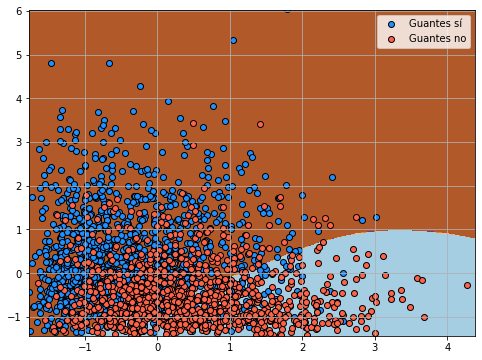

In [65]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_svm1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

Podemos observar que con esta medida de ajuste nuestro modelo no mejoró demasiado con respecto al que nos daba los parámetros por default.

* Matriz de confusión

In [66]:
class_names=['guantes no', 'guantes si']

In [67]:
from sklearn.metrics import plot_confusion_matrix

Matriz de confusión del conjunto de test
[[ 574  403]
 [ 195 1165]]


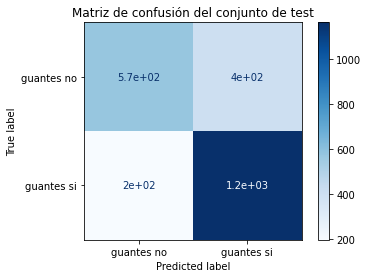

In [68]:
disp = plot_confusion_matrix(mejor_svm1, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[1286  912]
 [ 473 2782]]


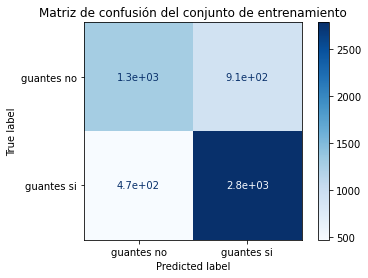

In [69]:
disp = plot_confusion_matrix(mejor_svm1, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Hay una gran cantidad de positivos verdaderos, superando los del conjunto de entrenamiento a los de test

In [70]:
from sklearn.metrics import classification_report

#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.73      0.59      0.65      2198
           1       0.75      0.85      0.80      3255

    accuracy                           0.75      5453
   macro avg       0.74      0.72      0.73      5453
weighted avg       0.74      0.75      0.74      5453



In [71]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66       977
           1       0.74      0.86      0.80      1360

    accuracy                           0.74      2337
   macro avg       0.74      0.72      0.73      2337
weighted avg       0.74      0.74      0.74      2337



## Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
guantes=df_pequeño_guantes.copy()
guantes['color']=df_pequeño_color['color']
guantes

,518,1563,guantes,color
0,-0.883125,-0.869236,1,0
1,-0.787633,-0.954215,1,0
2,-0.250995,2.911226,1,0
3,-0.835489,1.931537,1,0
4,-0.657238,0.266831,1,0
...,...,...,...,...
14527,-0.811635,-0.382077,1,1
14528,-0.638992,3.210943,1,1
14529,0.281971,1.524769,1,1
14530,-0.913069,-0.335468,1,1


In [74]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [76]:
[rfc.score(X_train, y_train),rfc.score(X_test,y_test)]

[0.9998166147075005, 0.7051775780915703]

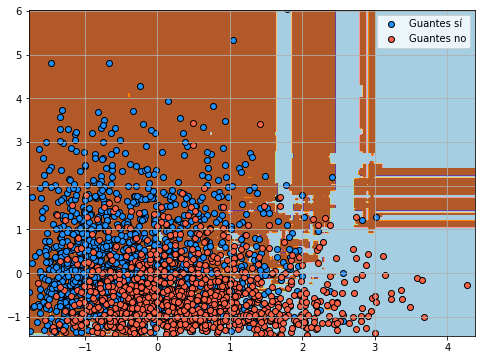

In [77]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = rfc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

In [78]:
param_grid = { 'criterion' : ['gini', 'entropy'], 
              #'min_samples_leaf' : [1, 5, 8,10], 
              'min_samples_split' : [2, 4, 10, 12], 
              'n_estimators': [50, 100, 400]
              }

In [79]:
rfc1 = RandomForestClassifier(random_state=0)
cv = GridSearchCV(rfc1, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

In [80]:
results = cv.cv_results_
df = pd.DataFrame(results)
feat_int=['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
df[feat_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
11,"{'criterion': 'gini', 'min_samples_split': 12,...",0.723641,0.008491,1
9,"{'criterion': 'gini', 'min_samples_split': 12,...",0.720892,0.012524,2
10,"{'criterion': 'gini', 'min_samples_split': 12,...",0.720523,0.009812,3


In [81]:
mejor_rfc1=cv.best_estimator_
[mejor_rfc1.score(X_train, y_train),mejor_rfc1.score(X_test,y_test)]

[0.8960205391527599, 0.7197261446298674]

In [82]:
mejor_rfc1.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)>

In [83]:
#Predecimos con modelo
y_best=mejor_rfc1.predict(X_test)
y_train_best=mejor_rfc1.predict(X_train)

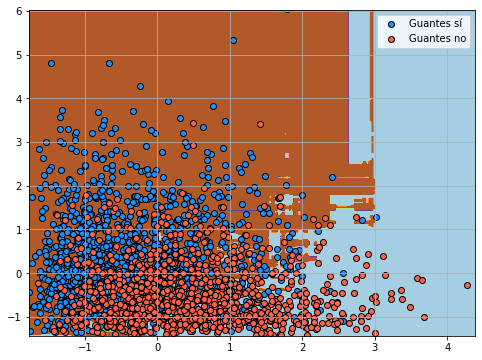

In [84]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_rfc1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

Matriz de confusión del conjunto de entrenamiento
[[1851  347]
 [ 220 3035]]


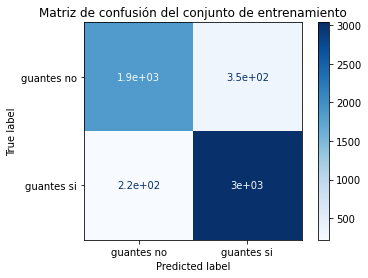

In [85]:
disp = plot_confusion_matrix(mejor_rfc1, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[ 597  380]
 [ 275 1085]]


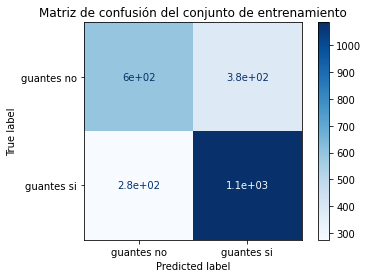

In [86]:
disp = plot_confusion_matrix(mejor_rfc1, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

In [87]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87      2198
           1       0.90      0.93      0.91      3255

    accuracy                           0.90      5453
   macro avg       0.90      0.89      0.89      5453
weighted avg       0.90      0.90      0.90      5453



In [88]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.68      0.61      0.65       977
           1       0.74      0.80      0.77      1360

    accuracy                           0.72      2337
   macro avg       0.71      0.70      0.71      2337
weighted avg       0.72      0.72      0.72      2337



##Clasificación multiclase de imágenes pequeñas

In [89]:
#Para el problema multiclase
X, y=g_arr_pequeño, arr_color
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

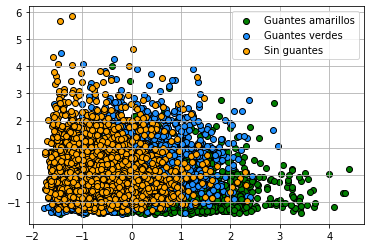

In [90]:
#Graficamos nuestro conjunto de datos
plt.scatter( X_train[:,0][y_train==2] , X_train[:,1][y_train==2], color="green", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_train[:,0][y_train==1] , X_train[:,1][y_train==1], color="dodgerblue", edgecolors='k', label="Guantes verdes")
plt.scatter( X_train[:,0][y_train==0] , X_train[:,1][y_train==0], color="orange", edgecolors='k', label="Sin guantes")
plt.grid()
plt.legend()
plt.show()

## KNN vecinos

In [91]:
from sklearn.neighbors import KNeighborsClassifier
vecinos_2 = KNeighborsClassifier()
vecinos_2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [92]:
[vecinos_2.score(X_train,y_train), vecinos_2.score(X_test,y_test)]

[0.6733907940583165, 0.5430038510911425]

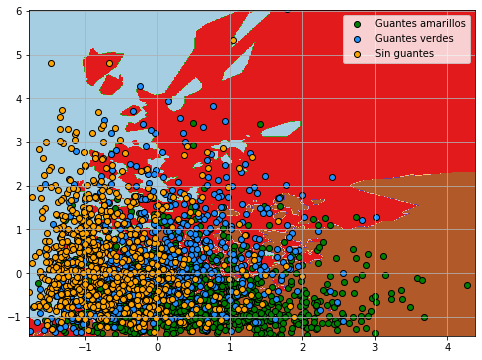

In [93]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = vecinos_2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="green", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="orange", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

In [94]:
#Ahora para varios k
train_errors = []
test_errors = []
sum_errors = []
vecinos = [1,2,4 ,5,10,15,20,25,30,35,40,50,60,70,80]
for vecino in vecinos:
    # Entrenamiento:
    vecinos_2 = KNeighborsClassifier(n_neighbors=vecino)
    vecinos_2.fit(X_train, y_train)
    
    # Predicción:
    y_train_pred = vecinos_2.predict(X_train)
    y_test_pred = vecinos_2.predict(X_test)
    
    # Evaluación:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    sum_errors.append(train_error + test_error)

    #Viusalizamos el error que se produce con cada polinomio
    print(f'Con grado {vecino} en entrenamiento error: {train_error:0.2}, prueba: {test_error:0.2}, suma: {test_error+train_error:0.2}')

Con grado 1 en entrenamiento error: 0.0, prueba: 0.94, suma: 0.94
Con grado 2 en entrenamiento error: 0.48, prueba: 0.99, suma: 1.5
Con grado 4 en entrenamiento error: 0.58, prueba: 0.89, suma: 1.5
Con grado 5 en entrenamiento error: 0.62, prueba: 0.86, suma: 1.5
Con grado 10 en entrenamiento error: 0.67, prueba: 0.8, suma: 1.5
Con grado 15 en entrenamiento error: 0.71, prueba: 0.77, suma: 1.5
Con grado 20 en entrenamiento error: 0.72, prueba: 0.76, suma: 1.5
Con grado 25 en entrenamiento error: 0.71, prueba: 0.77, suma: 1.5
Con grado 30 en entrenamiento error: 0.71, prueba: 0.77, suma: 1.5
Con grado 35 en entrenamiento error: 0.72, prueba: 0.77, suma: 1.5
Con grado 40 en entrenamiento error: 0.73, prueba: 0.76, suma: 1.5
Con grado 50 en entrenamiento error: 0.74, prueba: 0.75, suma: 1.5
Con grado 60 en entrenamiento error: 0.73, prueba: 0.74, suma: 1.5
Con grado 70 en entrenamiento error: 0.73, prueba: 0.75, suma: 1.5
Con grado 80 en entrenamiento error: 0.74, prueba: 0.74, suma: 1.5


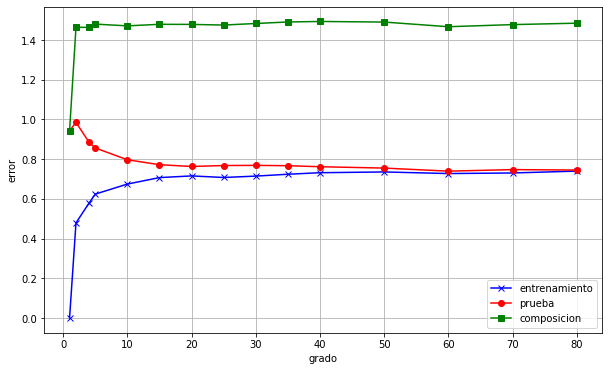

In [95]:
#Graficamos las curvas de error
plt.figure(figsize=(10,6))
plt.plot(vecinos, train_errors, '-x', color="blue", label="entrenamiento")
plt.plot(vecinos, test_errors, '-o', color="red", label="prueba")
plt.plot(vecinos, sum_errors, '-s', color="g", label="composicion")
plt.legend()
plt.xlabel("grado")
plt.ylabel("error")
plt.grid(True)
plt.show()

In [96]:
vecinos_2 = KNeighborsClassifier(n_neighbors=60)
vecinos_2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=60, p=2,
                     weights='uniform')

In [97]:
[vecinos_2.score(X_train,y_train), vecinos_2.score(X_test,y_test)]

[0.6099394828534751, 0.6007702182284981]

* Ahora con GridSearchCV

In [98]:
params_vecinos={
                'n_neighbors': [50,60,70,80,90], 
                'weights': ['uniform', 'distance'], 
                'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p':[1, 2],
                'metric':[ 'euclidean', 'minkowski', 'manhattan'],
                  
                }

In [99]:
vecinos_2=KNeighborsClassifier()
cv = GridSearchCV(vecinos_2, params_vecinos, scoring='neg_mean_squared_error', cv=5)
cv.fit(X_train,y_train);

In [100]:
results = cv.cv_results_
df = pd.DataFrame(results)
cols_int=['params','mean_test_score', 'std_test_score','rank_test_score']
df[cols_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
30,"{'algorithm': 'auto', 'metric': 'minkowski', '...",-0.751501,0.035329,1
150,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",-0.751501,0.035329,1
68,"{'algorithm': 'ball_tree', 'metric': 'euclidea...",-0.751501,0.035329,1


In [101]:
mejor_vecino2=cv.best_estimator_
[mejor_vecino2.score(X_train,y_train), mejor_vecino2.score(X_test,y_test)]

[0.6086557858059783, 0.6007702182284981]

In [102]:
mejor_vecino2.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=70, p=1,
                     weights='uniform')>

In [103]:
#Predecimos con el nuevo modelo
y_best=mejor_vecino2.predict(X_test)
y_train_best=mejor_vecino2.predict(X_train)

#Evaluación
train_error = mean_squared_error(y_train, y_train_best)
test_error = mean_squared_error(y_test, y_best)
print(f'Error de entrenamiento: {train_error:0.2}')
print(f'Error en prueba: {test_error:0.2}')

Error de entrenamiento: 0.73
Error en prueba: 0.75


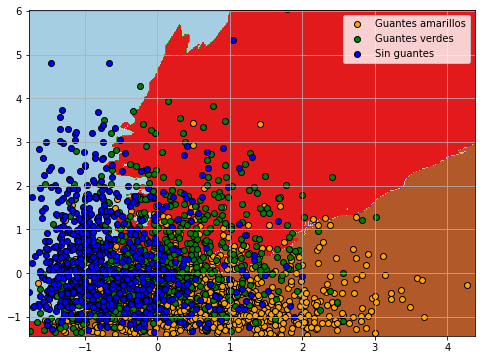

In [104]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_vecino2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

* Matriz de confusión

In [105]:
class_names2=['Sin guantes', 'Verdes', 'Amarillos']

Matriz de confusión del conjunto de test
[[416 124 172]
 [165 270 213]
 [ 99 160 718]]


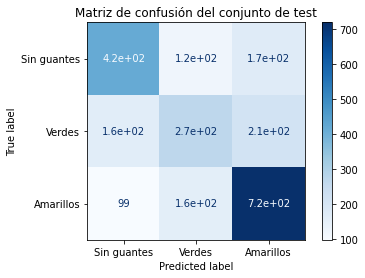

In [106]:
disp = plot_confusion_matrix(mejor_vecino2, X_test, y_test,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[ 992  303  392]
 [ 399  690  479]
 [ 224  337 1637]]


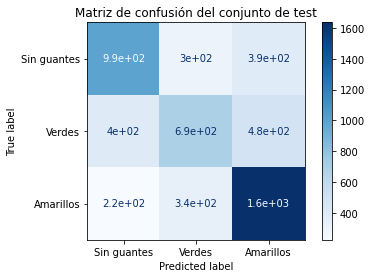

In [107]:
disp = plot_confusion_matrix(mejor_vecino2, X_train, y_train,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Podemos ver que hay una gran cantidad de verdaderos positivos, desetacando la categoría de guantes Amarillos.

In [108]:
#Reporte para el conjunto de prueba
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60       712
           1       0.49      0.42      0.45       648
           2       0.65      0.73      0.69       977

    accuracy                           0.60      2337
   macro avg       0.58      0.58      0.58      2337
weighted avg       0.59      0.60      0.60      2337



In [109]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1687
           1       0.52      0.44      0.48      1568
           2       0.65      0.74      0.70      2198

    accuracy                           0.61      5453
   macro avg       0.60      0.59      0.59      5453
weighted avg       0.60      0.61      0.60      5453



## SVM

In [110]:
#Para el problema multiclase
X, y=g_arr_pequeño, arr_color
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [111]:
svm2 = sklearn.svm.SVC(random_state=0)
svm2.fit(X_train, y_train);

In [112]:
svm2.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)>

In [113]:
[svm2.score(X_train, y_train), svm2.score(X_test,y_test)]

[0.6013203741059967, 0.6080445014976466]

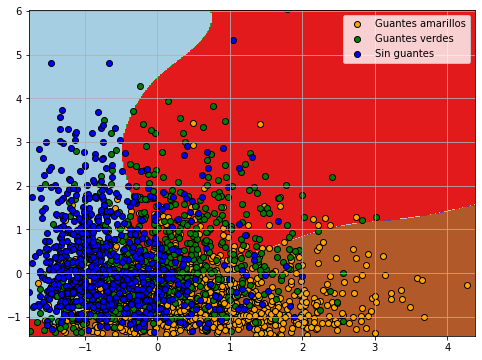

In [114]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = svm2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

* Ahora con GridSearchCV

In [115]:
param_grid = {
              'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']
              }

In [116]:
svm2 = sklearn.svm.SVC(random_state=0)
cv2 = GridSearchCV(svm2, param_grid,  scoring='accuracy',cv=5) 
cv2.fit(X_train, y_train);

In [117]:
results = cv2.cv_results_
df = pd.DataFrame(results)
feat_int=['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
df[feat_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
5,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.600040,0.009198,1
17,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.599855,0.005527,2
10,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.599673,0.009232,3


In [118]:
mejor_svm2=cv2.best_estimator_
[mejor_svm2.score(X_train, y_train), mejor_svm2.score(X_test,y_test)]

[0.6053548505409866, 0.6059050064184852]

In [119]:
mejor_svm2.get_params

<bound method BaseEstimator.get_params of SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)>

In [120]:
#Predecimos con el nuevo modelo
y_best=mejor_svm2.predict(X_test)
y_train_best=mejor_svm2.predict(X_train)

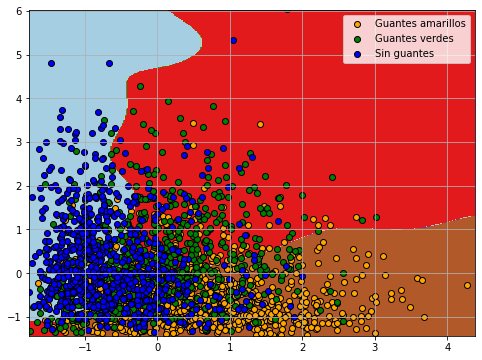

In [121]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_svm2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

* Matriz de confusión

In [122]:
class_names2=['Sin guantes', 'Verdes', 'Amarillos']

Matriz de confusión del conjunto de test
[[413 116 183]
 [163 267 218]
 [ 96 145 736]]


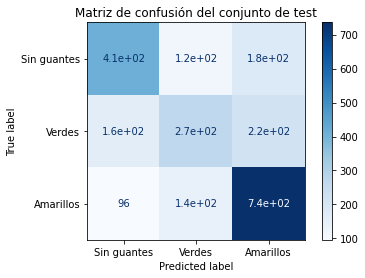

In [123]:
disp = plot_confusion_matrix(mejor_svm2, X_test, y_test,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[ 990  266  431]
 [ 405  641  522]
 [ 223  305 1670]]


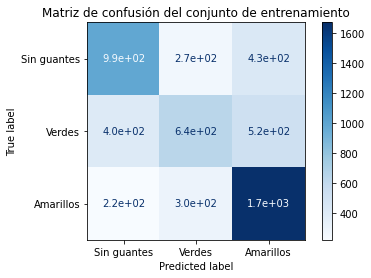

In [124]:
disp = plot_confusion_matrix(mejor_svm2, X_train, y_train,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Podemos ver que tanto para el conjunto de entrenamiento como para el de test existe una gran cantidad de verdaderos positivos.

* Reporte de clasificación

In [125]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60       712
           1       0.51      0.41      0.45       648
           2       0.65      0.75      0.70       977

    accuracy                           0.61      2337
   macro avg       0.59      0.58      0.58      2337
weighted avg       0.60      0.61      0.60      2337



In [126]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1687
           1       0.53      0.41      0.46      1568
           2       0.64      0.76      0.69      2198

    accuracy                           0.61      5453
   macro avg       0.59      0.59      0.58      5453
weighted avg       0.60      0.61      0.60      5453



## Random Forest

Convertimos nuestras variables categóricas en una matriz para identificar cada variable

In [127]:
c_guantes=df_pequeño_guantes.copy()
c_guantes['color']=df_pequeño_color['color']
c_guantes

,518,1563,guantes,color
0,-0.883125,-0.869236,1,0
1,-0.787633,-0.954215,1,0
2,-0.250995,2.911226,1,0
3,-0.835489,1.931537,1,0
4,-0.657238,0.266831,1,0
...,...,...,...,...
14527,-0.811635,-0.382077,1,1
14528,-0.638992,3.210943,1,1
14529,0.281971,1.524769,1,1
14530,-0.913069,-0.335468,1,1


In [128]:
feat_color=c_guantes.drop('color', axis=1)
feat_color=np.array(feat_color)
feat_color.shape

(7790, 3)

In [129]:
var_color=np.array(c_guantes['color'])
var_color.shape

(7790,)

In [130]:
#Separación de los datos
X, y=g_arr_pequeño, arr_color
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [131]:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [132]:
[rfc2.score(X_train, y_train), rfc2.score(X_test, y_test)]

[1.0, 0.5507060333761232]

In [133]:
rfc2.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

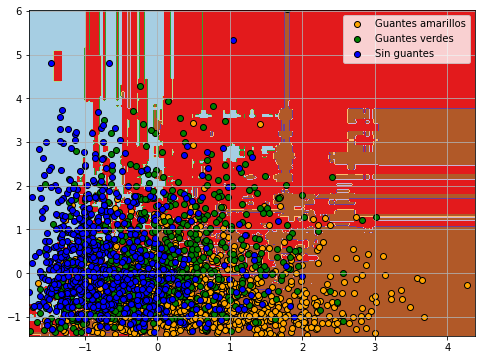

In [134]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = rfc2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

El random forest se ajustó demasiado a los datos de entrenamiento

In [135]:
param_grid = { 'criterion' : ['gini', 'entropy'], 
              'min_samples_split' : [2,5,10,20,30,40,50,60,70], 
              'n_estimators': [40,50,60,70]
              }

In [136]:
rfc2 = RandomForestClassifier()
cvr2 = GridSearchCV(rfc2, param_grid,  scoring='accuracy',cv=5) 
cvr2.fit(X_train, y_train);

In [137]:
results = cvr2.cv_results_
df = pd.DataFrame(results)
cols_int=['params','mean_test_score', 'std_test_score','rank_test_score']
df[cols_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
69,"{'criterion': 'entropy', 'min_samples_split': ...",0.599673,0.009284,1
28,"{'criterion': 'gini', 'min_samples_split': 60,...",0.598023,0.007476,2
67,"{'criterion': 'entropy', 'min_samples_split': ...",0.596556,0.011572,3


In [138]:
mejor_rfc2=cvr2.best_estimator_
[mejor_rfc2.score(X_train, y_train), mejor_rfc2.score(X_test,y_test)]

[0.6532184118833669, 0.6011981172443304]

In [139]:
mejor_rfc2.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=70,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [140]:
#Predecimos con modelo
y_best=mejor_rfc2.predict(X_test)
y_train_best=mejor_rfc2.predict(X_train)

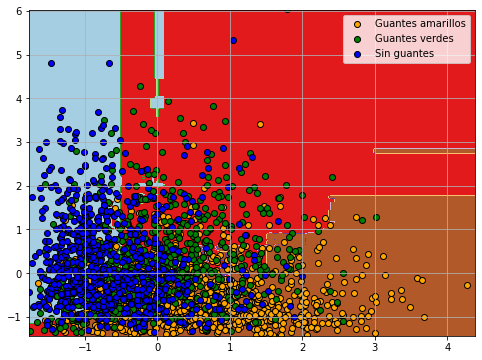

In [141]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_rfc2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

Matriz de confusión del conjunto de test
[[416 130 166]
 [167 277 204]
 [106 159 712]]


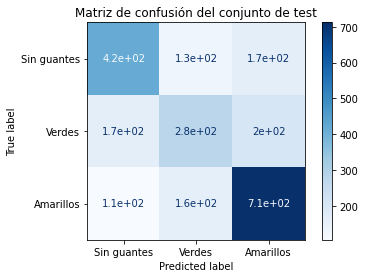

In [142]:
disp = plot_confusion_matrix(mejor_rfc2, X_test, y_test,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[1058  281  348]
 [ 350  786  432]
 [ 200  280 1718]]


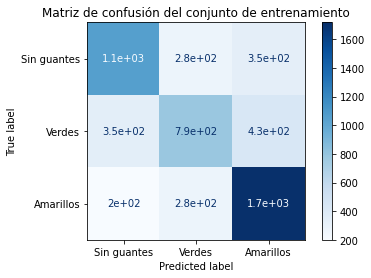

In [143]:
disp = plot_confusion_matrix(mejor_rfc2, X_train, y_train,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

In [144]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1687
           1       0.58      0.50      0.54      1568
           2       0.69      0.78      0.73      2198

    accuracy                           0.65      5453
   macro avg       0.64      0.64      0.64      5453
weighted avg       0.65      0.65      0.65      5453



In [145]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       712
           1       0.49      0.43      0.46       648
           2       0.66      0.73      0.69       977

    accuracy                           0.60      2337
   macro avg       0.58      0.58      0.58      2337
weighted avg       0.59      0.60      0.60      2337



# **Imágenes grandes**

In [146]:
df_grande_cod=df_grande.copy()
df_grande_cod['guantes']=preprocessing.LabelEncoder() .fit_transform(df_grande['guantes'])
df_grande_cod['color']=preprocessing.LabelEncoder() .fit_transform(df_grande['color'])
df_grande_cod.head()

,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
701,M_P_Mostrando_Amarillos_0_single_box.jpg,888,958,246,297,M,P,70,51,3570,1,0,0.145595,0.213514,0.791483,0.072909,0.097112,0.352617,0.259018,1.360401,0.550221,0.154716,0.021366,0.024072,0.949577,0.064469,0.284966,0.055286,0.345928,0.326021,0.793031,0.021018,0.026289,0.323501,0.217253,0.247845,0.000000,0.101313,0.169508,0.077822,...,0.025705,0.417304,0.033816,0.173230,0.051771,1.415602,0.337321,0.975691,0.550020,0.641819,0.439040,0.029718,0.301447,0.116038,0.839936,0.124410,0.249364,0.014110,0.516542,0.389848,0.184664,0.209011,0.055636,0.754151,0.081306,0.112539,0.030242,0.100436,0.059771,0.097028,0.224595,0.477608,0.254312,0.466399,0.530521,1.133145,0.532193,0.372313,0.255801,0.007732
702,M_P_Mostrando_Amarillos_100_double_box1.jpg,1039,1126,152,213,M,P,87,61,5307,1,0,0.633379,0.302466,1.012172,0.099294,0.621903,0.316363,0.465347,0.853991,0.348377,0.533595,0.074831,0.039681,0.317442,0.000000,0.289752,0.113386,0.212390,0.039103,0.018105,0.190704,0.073810,0.538579,0.840063,0.128677,0.630762,0.083598,0.126321,0.545839,...,0.493111,0.462204,0.077777,0.009331,0.571931,2.391589,0.827531,0.060029,0.321658,0.492403,1.175636,0.055608,0.406178,0.415775,1.158667,0.006724,0.033182,0.024130,1.273448,0.427369,0.344070,0.243982,0.014488,2.060503,0.372567,0.062778,0.772663,0.630821,0.237646,0.604410,0.252473,0.293842,0.053953,0.081763,1.139570,0.293480,0.567158,0.168934,2.355879,0.037785
703,M_P_Mostrando_Amarillos_100_double_box2.jpg,871,943,215,269,M,P,72,54,3888,1,0,0.319083,0.094527,1.127734,0.534825,0.190210,0.021705,0.687998,0.856857,0.183420,0.474442,0.044079,0.185068,0.509284,0.026576,0.106728,0.060262,0.263037,0.507972,0.818271,0.021119,0.121881,0.278807,0.396050,0.198627,0.027860,0.000000,0.164530,0.146234,...,0.068353,0.626280,0.000000,0.245522,0.234813,1.132762,0.057690,0.483179,0.777851,0.194896,0.506794,0.051573,0.175273,0.012522,1.179126,0.221046,0.641441,0.569595,0.262994,0.444106,0.629760,0.600889,0.173166,0.754283,0.377667,0.170891,0.124353,0.112478,0.061948,0.029943,0.440217,0.215177,0.495561,0.172839,1.033710,0.106296,0.377070,0.361771,0.199704,0.013590
704,M_P_Mostrando_Amarillos_101_double_box1.jpg,1040,1127,163,223,M,P,87,60,5220,1,0,0.575334,0.248833,1.490522,0.171864,0.495312,0.408600,0.536777,0.858524,0.630678,0.562686,0.104928,0.146866,0.423804,0.000000,0.159510,0.034980,0.053543,0.041939,0.057739,0.201945,0.104608,0.268199,0.749754,0.125202,0.566573,0.075803,0.099521,0.598224,...,0.252012,0.414926,0.018097,0.000965,0.530335,2.265138,0.879306,0.120637,0.428749,0.276193,0.925675,0.045629,0.201032,0.316982,0.869703,0.000000,0.092286,0.061382,0.851333,0.402125,0.313476,0.209744,0.024088,1.917398,0.362814,0.044798,0.627235,0.703767,0.114861,0.443582,0.318358,0.170784,0.277719,0.106346,0.967500,0.261244,0.286027,0.223086,1.496811,0.014148
705,M_P_Mostrando_Amarillos_101_double_box2.jpg,864,946,199,261,M,P,82,62,5084,1,0,0.442127,0.315284,0.803918,0.750908,0.182241,0.187923,0.368746,1.404423,1.020987,0.550801,0.683092,0.114155,0.281627,0.152793,0.039259,0.036205,0.564970,0.983473,0.522391,0.063518,0.237685,0.442100,0.706219,0.288865,0.568493,0.063661,0.286854,0.271709,...,0.063464,0.559473,0.000000,0.461803,0.612293,1.447132,0.153196,0.719833,0.397317,0.538565,0.513206,0.496623,0.479347,0.009234,0.558104,0.139869,0.504194,0.065306,0.410058,0.851409,0.581926,0.477313,0.211720,0.683624,0.388145,0.117304,0.006243,0.109897,0.197557,0.057772,0.546276,0.210048,0.673676,0.459136,2.006826,0.364663,0.371868,0.046359,0.329710,0.059402


In [147]:
feat_guantes_grande=['1202', '1933']

In [148]:
var_grande_guantes=np.array(df_grande_cod[feat_guantes_grande])
var_grande_guantes_sc = preprocessing.StandardScaler().fit_transform(var_grande_guantes)

#Pasamos los datos a un dataframe
df_var_grande_guantes=pd.DataFrame(data=var_grande_guantes_sc, index=df_grande.index, columns=feat_guantes_grande)
df_var_grande_guantes.head(3)

,1202,1933
701,3.568418,-0.970036
702,1.807469,1.946907
703,1.085688,-0.271683


In [149]:
df_var_grande_guantes['Guantes']=df_grande_cod['guantes']
df_var_grande_guantes['Color']=df_grande_cod['color']

In [150]:
df_var_grande_guantes

,1202,1933,Guantes,Color
701,3.568418,-0.970036,1,0
702,1.807469,1.946907,1,0
703,1.085688,-0.271683,1,0
704,1.992446,0.751758,1,0
705,1.397322,-0.287625,1,0
...,...,...,...,...
15192,-0.920538,0.318135,1,1
15193,-0.685206,-0.977013,1,1
15194,-0.887719,-0.614202,1,1
15195,-0.345918,-0.181019,1,1


In [151]:
#Vectorizacion
g_arr_grande=np.array(df_var_grande_guantes[feat_guantes_grande])
g_arr_grande.shape

(7407, 2)

In [152]:
#Etiquetas para clasificación binaria
arr_guantes_grande=np.array(df_var_grande_guantes['Guantes'])
arr_guantes_grande.shape

(7407,)

In [153]:
arr_color_grande=np.array(df_var_grande_guantes['Color'])
arr_color_grande.shape

(7407,)

## Clasificación binaria imágenes grandes

## KNN vecinos

In [154]:
#Separación de nuestros datos
X, y=g_arr_grande, arr_guantes_grande
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

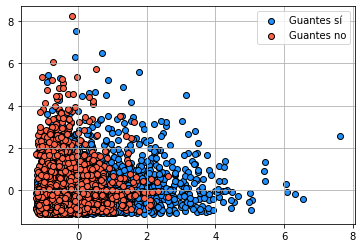

In [155]:
#Graficamos nuestro conjunto de datos
plt.scatter( X_train[:,0][y_train==1] , X_train[:,1][y_train==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_train[:,0][y_train==0] , X_train[:,1][y_train==0], color="tomato", edgecolors='k', label="Guantes no")
plt.grid()
plt.legend()
plt.show()

In [156]:
vecinos_3 = KNeighborsClassifier()
vecinos_3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [157]:
[vecinos_3.score(X_train,y_train), vecinos_3.score(X_test,y_test)]

[0.7395833333333334, 0.6054880791722898]

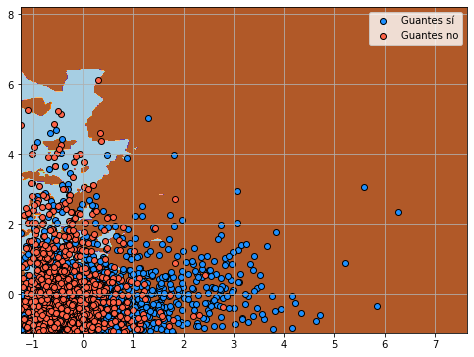

In [158]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = vecinos_3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

In [159]:
#Ahora para varios k
train_errors = []
test_errors = []
sum_errors = []
vecinos = [1, 2,5,8,10,15,20,25,30,40,50,60,70]
for vecino in vecinos:
    # Entrenamiento:
    vecinos_3 = KNeighborsClassifier(n_neighbors=vecino)
    vecinos_3.fit(X_train, y_train)
    
    # Predicción:
    y_train_pred = vecinos_3.predict(X_train)
    y_test_pred = vecinos_3.predict(X_test)
    
    # Evaluación:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    sum_errors.append(train_error + test_error)

    #Viusalizamos el error que se produce con cada polinomio
    print(f'Con grado {vecino} en entrenamiento error: {train_error:0.2}, prueba: {test_error:0.2}, suma: {test_error+train_error:0.2}')

Con grado 1 en entrenamiento error: 0.0, prueba: 0.43, suma: 0.43
Con grado 2 en entrenamiento error: 0.22, prueba: 0.48, suma: 0.69
Con grado 5 en entrenamiento error: 0.26, prueba: 0.39, suma: 0.65
Con grado 8 en entrenamiento error: 0.29, prueba: 0.4, suma: 0.69
Con grado 10 en entrenamiento error: 0.3, prueba: 0.39, suma: 0.69
Con grado 15 en entrenamiento error: 0.32, prueba: 0.37, suma: 0.68
Con grado 20 en entrenamiento error: 0.33, prueba: 0.38, suma: 0.7
Con grado 25 en entrenamiento error: 0.33, prueba: 0.37, suma: 0.7
Con grado 30 en entrenamiento error: 0.33, prueba: 0.38, suma: 0.71
Con grado 40 en entrenamiento error: 0.34, prueba: 0.37, suma: 0.71
Con grado 50 en entrenamiento error: 0.34, prueba: 0.36, suma: 0.7
Con grado 60 en entrenamiento error: 0.34, prueba: 0.36, suma: 0.7
Con grado 70 en entrenamiento error: 0.34, prueba: 0.36, suma: 0.7


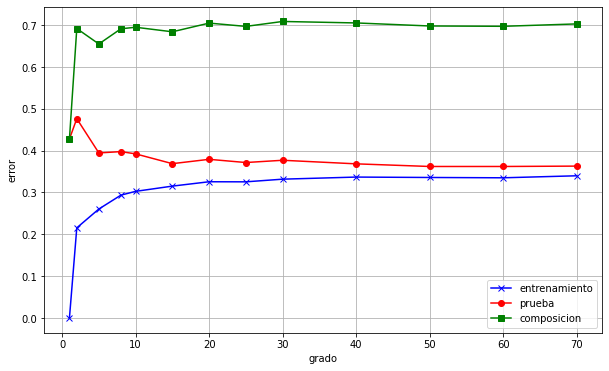

In [160]:
#Graficamos las curvas de error
plt.figure(figsize=(10,6))
plt.plot(vecinos, train_errors, '-x', color="blue", label="entrenamiento")
plt.plot(vecinos, test_errors, '-o', color="red", label="prueba")
plt.plot(vecinos, sum_errors, '-s', color="g", label="composicion")
plt.legend()
plt.xlabel("grado")
plt.ylabel("error")
plt.grid(True)
plt.show()

Vemos que el error de prueba siempre se mantiene por encima del de entrenamiento, tratamos de buscar el que tenga menor valor.

In [161]:
vecinos_3=KNeighborsClassifier(n_neighbors=50)
vecinos_3.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [162]:
[vecinos_3.score(X_train, y_train), vecinos_3.score(X_test, y_test)]

[0.6641589506172839, 0.6378767431399011]

Se observa un pequeño overfitting. Tratamos de mejorar nuestros resultados con GridSearchCV.

In [163]:
params_vecinos={
                'n_neighbors': [40,50,60,70,80,90], 
                'weights': ['uniform', 'distance'], 
                'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p':[1, 2],
                'metric':[ 'euclidean', 'minkowski', 'manhattan'],
                  
                }

In [164]:
vecinos_3=KNeighborsClassifier()
cv=GridSearchCV(vecinos_3, params_vecinos, scoring='neg_mean_squared_error', cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': [40, 50, 60, 70, 80, 90], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [165]:
results = cv.cv_results_
df = pd.DataFrame(results)
cols_int=['params','mean_test_score', 'std_test_score','rank_test_score']
df[cols_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
210,"{'algorithm': 'kd_tree', 'metric': 'manhattan'...",-0.345293,0.005987,1
184,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",-0.345293,0.005987,1
136,"{'algorithm': 'ball_tree', 'metric': 'manhatta...",-0.345293,0.005987,1


In [166]:
mejor_vecino3=cv.best_estimator_
[mejor_vecino3.score(X_train, y_train), mejor_vecino3.score(X_test, y_test)]

[0.6614583333333334, 0.6374269005847953]

In [167]:
#Predecimos con el nuevo modelo
y_best=mejor_vecino3.predict(X_test)
y_train_best=mejor_vecino3.predict(X_train)

#Evaluación
train_error = mean_squared_error(y_train, y_train_best)
test_error = mean_squared_error(y_test, y_best)
print(f'Error de entrenamiento: {train_error:0.2}')
print(f'Error en prueba: {test_error:0.2}')

Error de entrenamiento: 0.34
Error en prueba: 0.36


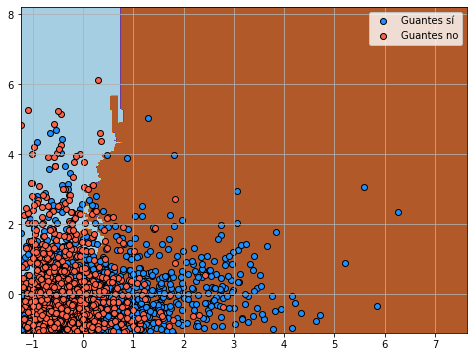

In [168]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_vecino3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

Matriz de confusión del conjunto de test
[[ 210  638]
 [ 168 1207]]


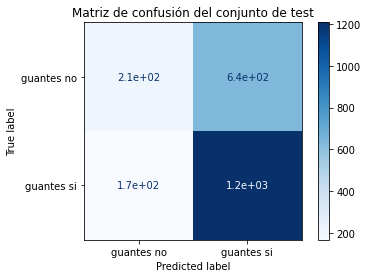

In [169]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(mejor_vecino3, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[ 513 1409]
 [ 346 2916]]


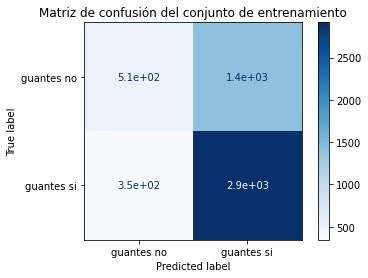

In [170]:
disp = plot_confusion_matrix(mejor_vecino3, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Se puede ver que tanto para el conjunto de datos de entrenamiento como para los de prueba hay una gran cantidad de verdaderos positivos

In [171]:
#Reporte para el conjunto de prueba
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.56      0.25      0.34       848
           1       0.65      0.88      0.75      1375

    accuracy                           0.64      2223
   macro avg       0.60      0.56      0.55      2223
weighted avg       0.62      0.64      0.59      2223



In [172]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.60      0.27      0.37      1922
           1       0.67      0.89      0.77      3262

    accuracy                           0.66      5184
   macro avg       0.64      0.58      0.57      5184
weighted avg       0.65      0.66      0.62      5184



## SVM

In [173]:
X, y=g_arr_grande, arr_guantes_grande
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [174]:
[X_train.shape, X_test.shape]

[(5184, 2), (2223, 2)]

In [175]:
svm3 = sklearn.svm.SVC()
svm3.fit(X_train, y_train);

In [176]:
svm3.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

In [177]:
[svm3.score(X_train,y_train), svm3.score(X_test,y_test)]

[0.6537422839506173, 0.6392262708052182]

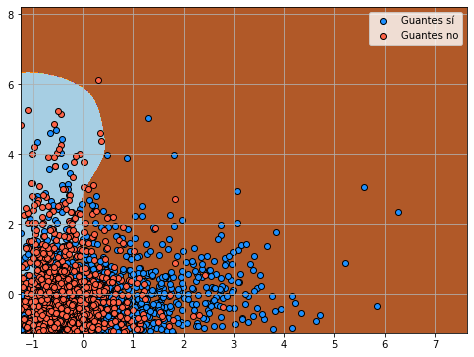

In [178]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = svm3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

* Ahora con GridSearchCV

In [179]:
param_grid = {
              'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']
              }


In [180]:
svm3 = sklearn.svm.SVC()
cv = GridSearchCV(svm3, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

In [181]:
results = cv.cv_results_
df = pd.DataFrame(results)
feat_int=['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
df[feat_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
20,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.652971,0.009380,1
15,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.652778,0.008061,2
5,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.652007,0.009245,3


In [182]:
mejor_svm3=cv.best_estimator_
[mejor_svm3.score(X_train, y_train), mejor_svm3.score(X_test, y_test)]

[0.6599151234567902, 0.6396761133603239]

In [183]:
mejor_svm3.get_params

<bound method BaseEstimator.get_params of SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)>

In [184]:
#Predecimos con el nuevo modelo
y_best=mejor_svm3.predict(X_test)
y_train_best=mejor_svm3.predict(X_train)

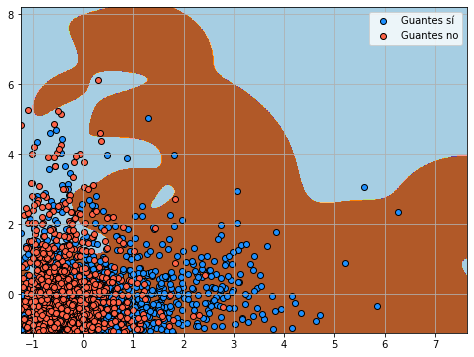

In [185]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_svm3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes sí")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="tomato", edgecolors='k', label="Guantes no")

plt.grid()
plt.legend()
plt.show()

* Matriz de confusión

Matriz de confusión del conjunto de entrenamiento
[[ 429 1493]
 [ 270 2992]]


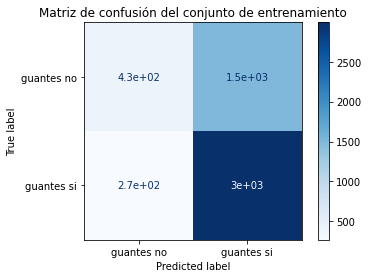

In [186]:
disp = plot_confusion_matrix(mejor_svm3, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de test
[[ 176  672]
 [ 129 1246]]


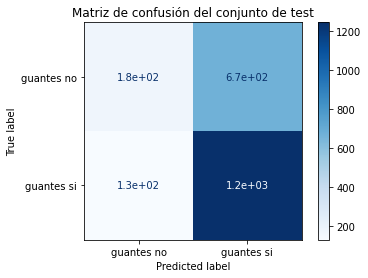

In [187]:
disp = plot_confusion_matrix(mejor_svm3, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

In [188]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.58      0.21      0.31       848
           1       0.65      0.91      0.76      1375

    accuracy                           0.64      2223
   macro avg       0.61      0.56      0.53      2223
weighted avg       0.62      0.64      0.58      2223



In [189]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.61      0.22      0.33      1922
           1       0.67      0.92      0.77      3262

    accuracy                           0.66      5184
   macro avg       0.64      0.57      0.55      5184
weighted avg       0.65      0.66      0.61      5184



## Random Forest

In [190]:
g_grande=df_var_grande_guantes.drop('Guantes', axis=1)
g_grande

,1202,1933,Color
701,3.568418,-0.970036,0
702,1.807469,1.946907,0
703,1.085688,-0.271683,0
704,1.992446,0.751758,0
705,1.397322,-0.287625,0
...,...,...,...
15192,-0.920538,0.318135,1
15193,-0.685206,-0.977013,1
15194,-0.887719,-0.614202,1
15195,-0.345918,-0.181019,1


In [191]:
g_grande=pd.get_dummies(g_grande, columns=['Color'], dummy_na=False)
g_grande

,1202,1933,Color_0,Color_1,Color_2
701,3.568418,-0.970036,1,0,0
702,1.807469,1.946907,1,0,0
703,1.085688,-0.271683,1,0,0
704,1.992446,0.751758,1,0,0
705,1.397322,-0.287625,1,0,0
...,...,...,...,...,...
15192,-0.920538,0.318135,0,1,0
15193,-0.685206,-0.977013,0,1,0
15194,-0.887719,-0.614202,0,1,0
15195,-0.345918,-0.181019,0,1,0


In [192]:
g_grande_tg=df_var_grande_guantes['Guantes']

In [193]:
g_grande_tg

701      1
702      1
703      1
704      1
705      1
        ..
15192    1
15193    1
15194    1
15195    1
15196    1
Name: Guantes, Length: 7407, dtype: int64

In [194]:
X, y=g_grande, g_grande_tg
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [195]:
rfc3=RandomForestClassifier()
rfc3.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [196]:
[rfc3.score(X_train, y_train), rfc3.score(X_test, y_test)]

[1.0, 1.0]

In [197]:
y_pred=rfc3.predict(X_test)
y_train_pred=rfc3.predict(X_train)

In [198]:
from sklearn.metrics import mean_squared_error

In [199]:
#probar de hacer con todo el dataset (en el dataset de muestra)
#Probar hacer con todas las features

* Matriz de confusión

Matriz de confusión del conjunto de entrenamiento
[[1922    0]
 [   0 3262]]


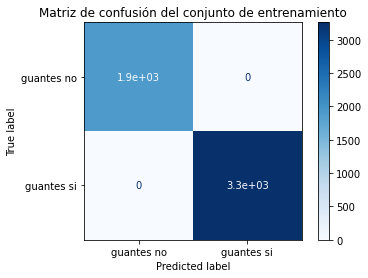

In [200]:
disp = plot_confusion_matrix(rfc3, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[ 848    0]
 [   0 1375]]


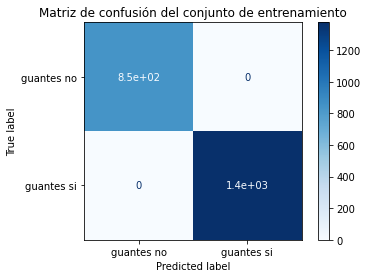

In [201]:
disp = plot_confusion_matrix(rfc3, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

In [202]:
#Predecimos con modelo
y_best=rfc3.predict(X_test)
y_train_best=rfc3.predict(X_train)

In [203]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1922
           1       1.00      1.00      1.00      3262

    accuracy                           1.00      5184
   macro avg       1.00      1.00      1.00      5184
weighted avg       1.00      1.00      1.00      5184



In [204]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       848
           1       1.00      1.00      1.00      1375

    accuracy                           1.00      2223
   macro avg       1.00      1.00      1.00      2223
weighted avg       1.00      1.00      1.00      2223



# Clasificación multiclase imágenes grandes

In [205]:
X, y=g_arr_grande, arr_color_grande
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

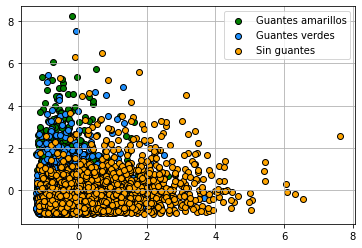

In [206]:
#Graficamos nuestro conjunto de datos
plt.scatter( X_train[:,0][y_train==2] , X_train[:,1][y_train==2], color="green", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_train[:,0][y_train==1] , X_train[:,1][y_train==1], color="dodgerblue", edgecolors='k', label="Guantes verdes")
plt.scatter( X_train[:,0][y_train==0] , X_train[:,1][y_train==0], color="orange", edgecolors='k', label="Sin guantes")
plt.grid()
plt.legend()
plt.show()

 # KNN vecinos

In [207]:
vecinos_4 = KNeighborsClassifier()
vecinos_4.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [208]:
[vecinos_4.score(X_train, y_train), vecinos_4.score(X_test, y_test)]

[0.6304012345679012, 0.4511920827710301]

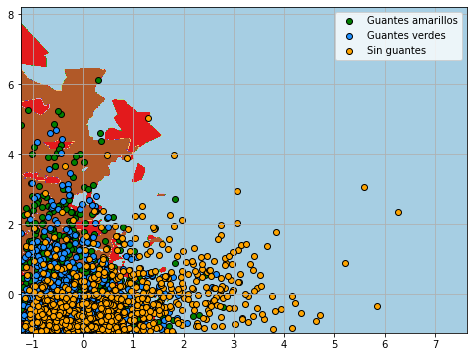

In [209]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = vecinos_4.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="green", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="orange", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

* Tratamos de buscar el número óptimo de K para producir el menor error posible

In [210]:
#Ahora para varios k
train_errors = []
test_errors = []
sum_errors = []
vecinos = [1, 2,4,8,10,15,21, 35,40, 45, 50, 57,63,75,83]
for vecino in vecinos:
    # Entrenamiento:
    vecinos_4 = KNeighborsClassifier(n_neighbors=vecino)
    vecinos_4.fit(X_train, y_train)
    
    # Predicción:
    y_train_pred = vecinos_4.predict(X_train)
    y_test_pred = vecinos_4.predict(X_test)
    
    # Evaluación:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    sum_errors.append(train_error + test_error)

    #Viusalizamos el error que se produce con cada polinomio
    print(f'Con grado {vecino} en entrenamiento error: {train_error:0.2}, prueba: {test_error:0.2}, suma: {test_error+train_error:0.2}')

Con grado 1 en entrenamiento error: 0.0, prueba: 1.1, suma: 1.1
Con grado 2 en entrenamiento error: 0.52, prueba: 1.1, suma: 1.6
Con grado 4 en entrenamiento error: 0.64, prueba: 0.99, suma: 1.6
Con grado 8 en entrenamiento error: 0.75, prueba: 0.96, suma: 1.7
Con grado 10 en entrenamiento error: 0.77, prueba: 0.95, suma: 1.7
Con grado 15 en entrenamiento error: 0.82, prueba: 0.94, suma: 1.8
Con grado 21 en entrenamiento error: 0.82, prueba: 0.92, suma: 1.7
Con grado 35 en entrenamiento error: 0.82, prueba: 0.92, suma: 1.7
Con grado 40 en entrenamiento error: 0.83, prueba: 0.91, suma: 1.7
Con grado 45 en entrenamiento error: 0.83, prueba: 0.91, suma: 1.7
Con grado 50 en entrenamiento error: 0.84, prueba: 0.9, suma: 1.7
Con grado 57 en entrenamiento error: 0.84, prueba: 0.89, suma: 1.7
Con grado 63 en entrenamiento error: 0.84, prueba: 0.9, suma: 1.7
Con grado 75 en entrenamiento error: 0.86, prueba: 0.91, suma: 1.8
Con grado 83 en entrenamiento error: 0.86, prueba: 0.9, suma: 1.8


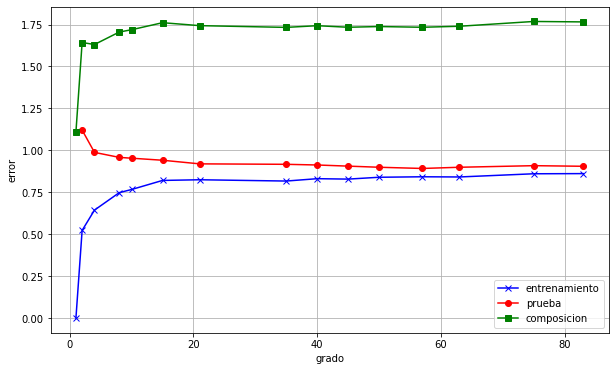

In [211]:
#Graficamos las curvas de error
plt.figure(figsize=(10,6))
plt.plot(vecinos, train_errors, '-x', color="blue", label="entrenamiento")
plt.plot(vecinos, test_errors, '-o', color="red", label="prueba")
plt.plot(vecinos, sum_errors, '-s', color="g", label="composicion")
plt.legend()
plt.xlabel("grado")
plt.ylabel("error")
plt.grid(True)
plt.show()

Parecido al conjunto de imágenes grandes, el error de prueba se mantiene mayor al de entrenamiento en todos los K hasta llegar a un valor de 100. Elegimos aquel que proporciona menor error de prueba.

In [212]:
vecinos_4 = KNeighborsClassifier(n_neighbors=57)
vecinos_4.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=57, p=2,
                     weights='uniform')

In [213]:
[vecinos_4.score(X_train, y_train), vecinos_4.score(X_test, y_test)]

[0.5300925925925926, 0.48493027440395864]

* Ahora con GridSearchCV

In [214]:
params_vecinos={
                'n_neighbors': [45,49,53,57,63,67], 
                'weights': ['uniform', 'distance'], 
                'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p':[1, 2],
                'metric':[ 'euclidean', 'minkowski', 'manhattan'],
                  
                }

In [215]:
vecinos_4=KNeighborsClassifier()
cv=GridSearchCV(vecinos_4, params_vecinos, scoring='neg_mean_squared_error', cv=5)
cv.fit(X_train, y_train);

In [216]:
results = cv.cv_results_
df = pd.DataFrame(results)
cols_int=['params','mean_test_score', 'std_test_score','rank_test_score']
df[cols_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
178,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",-0.884061,0.046967,1
34,"{'algorithm': 'auto', 'metric': 'minkowski', '...",-0.884061,0.046967,1
82,"{'algorithm': 'ball_tree', 'metric': 'euclidea...",-0.884061,0.046967,1


In [217]:
mejor_vecino4=cv.best_estimator_
[mejor_vecino4.score(X_train, y_train), mejor_vecino4.score(X_test, y_test)]

[0.5285493827160493, 0.4808816914080072]

In [218]:
#Predecimos con el nuevo modelo
y_best=mejor_vecino4.predict(X_test)
y_train_best=mejor_vecino4.predict(X_train)

#Evaluación
train_error = mean_squared_error(y_train, y_train_best)
test_error = mean_squared_error(y_test, y_best)
print(f'Error de entrenamiento: {train_error:0.2}')
print(f'Error en prueba: {test_error:0.2}')

Error de entrenamiento: 0.84
Error en prueba: 0.91


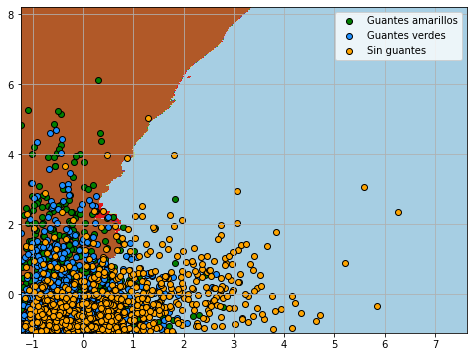

In [219]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_vecino4.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="green", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="dodgerblue", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="orange", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

Matriz de confusión del conjunto de test
[[388 137 170]
 [ 94 249 337]
 [117 299 432]]


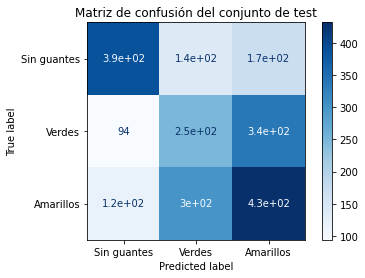

In [220]:
disp = plot_confusion_matrix(mejor_vecino4, X_test, y_test,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[ 904  312  382]
 [ 232  727  705]
 [ 247  566 1109]]


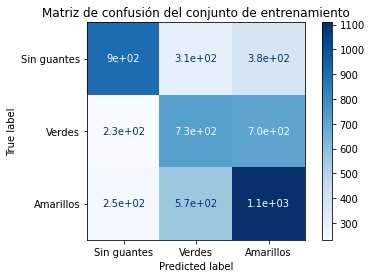

In [221]:
disp = plot_confusion_matrix(mejor_vecino4, X_train, y_train,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

En ambos conjuntos, de test y entrenamiento, podemos ver que hay una gran cantidad de verdaderos positivos.

In [222]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       695
           1       0.36      0.37      0.36       680
           2       0.46      0.51      0.48       848

    accuracy                           0.48      2223
   macro avg       0.49      0.48      0.48      2223
weighted avg       0.49      0.48      0.48      2223



In [223]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.65      0.57      0.61      1598
           1       0.45      0.44      0.44      1664
           2       0.51      0.58      0.54      1922

    accuracy                           0.53      5184
   macro avg       0.54      0.53      0.53      5184
weighted avg       0.53      0.53      0.53      5184



## SVM

In [224]:
X, y=g_arr_grande, arr_color_grande
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [225]:
svm4=sklearn.svm.SVC()
svm4.fit(X_train, y_train);

In [226]:
svm4.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

In [227]:
[svm4.score(X_train,y_train), svm4.score(X_test,y_test)]

[0.5046296296296297, 0.5146198830409356]

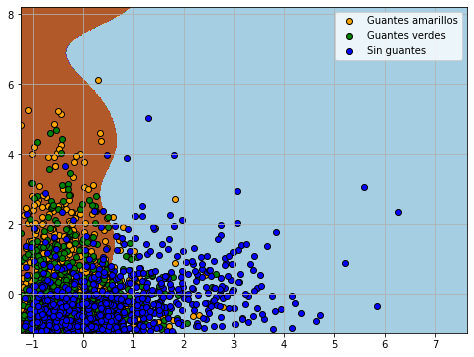

In [228]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = svm4.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

* Ahora con GridSearchCv

In [229]:
param_grid = {
              'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']
              }


In [230]:
svm4 = sklearn.svm.SVC()
cv = GridSearchCV(svm4, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

In [231]:
results = cv.cv_results_
df = pd.DataFrame(results)
feat_int=['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
df[feat_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
5,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.500387,0.010014,1
21,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.497301,0.011498,2
0,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.496723,0.011790,3


In [232]:
mejor_svm4=cv.best_estimator_
[mejor_svm4.score(X_train,y_train), mejor_svm4.score(X_test,y_test)]

[0.5021219135802469, 0.51102114260009]

In [233]:
mejor_svm4.get_params

<bound method BaseEstimator.get_params of SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)>

In [234]:
#Predecimos con el nuevo modelo
y_best=mejor_svm4.predict(X_test)
y_train_best=mejor_svm4.predict(X_train)

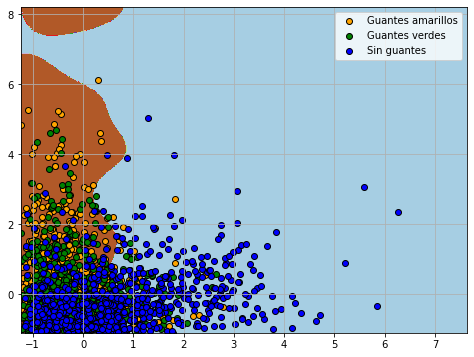

In [235]:
plt.figure(figsize=([8,6]))
#Graficamos nuestra frontera de decisión
x_start = min(np.min(X_train[:,0]), np.min(X_test[:,0]))
x_end = max(np.max(X_train[:,0]), np.max(X_test[:,0]))
y_start = min(np.min(X_train[:,1]), np.min(X_test[:,1]))
y_end = max(np.max(X_train[:,1]), np.max(X_test[:,1]))

xx, yy= np.meshgrid(np.arange(x_start, x_end, 0.02),
                      np.arange(y_start, y_end,0.02))

Z = mejor_svm4.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

plt.axis("tight")

#Graficamos nuestro conjunto de test
plt.scatter( X_test[:,0][y_test==2] , X_test[:,1][y_test==2], color="orange", edgecolors='k', label="Guantes amarillos")
plt.scatter( X_test[:,0][y_test==1] , X_test[:,1][y_test==1], color="green", edgecolors='k', label="Guantes verdes")
plt.scatter( X_test[:,0][y_test==0] , X_test[:,1][y_test==0], color="blue", edgecolors='k', label="Sin guantes")

plt.grid()
plt.legend()
plt.show()

Matriz de confusión del conjunto de entrenamiento
[[ 881  241  476]
 [ 224  564  876]
 [ 239  525 1158]]


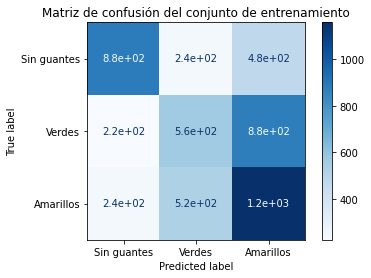

In [236]:
disp = plot_confusion_matrix(mejor_svm4, X_train, y_train,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[403 106 186]
 [ 93 216 371]
 [117 214 517]]


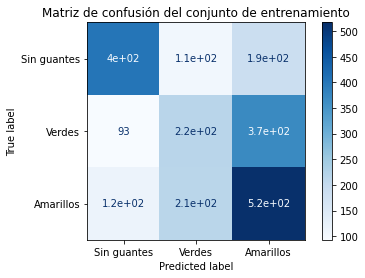

In [237]:
disp = plot_confusion_matrix(mejor_svm4, X_test, y_test,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

In [238]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1598
           1       0.42      0.34      0.38      1664
           2       0.46      0.60      0.52      1922

    accuracy                           0.50      5184
   macro avg       0.51      0.50      0.50      5184
weighted avg       0.51      0.50      0.50      5184



In [239]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62       695
           1       0.40      0.32      0.36       680
           2       0.48      0.61      0.54       848

    accuracy                           0.51      2223
   macro avg       0.51      0.50      0.50      2223
weighted avg       0.51      0.51      0.51      2223



## Random Forest

In [240]:
df_var_grande_guantes

,1202,1933,Guantes,Color
701,3.568418,-0.970036,1,0
702,1.807469,1.946907,1,0
703,1.085688,-0.271683,1,0
704,1.992446,0.751758,1,0
705,1.397322,-0.287625,1,0
...,...,...,...,...
15192,-0.920538,0.318135,1,1
15193,-0.685206,-0.977013,1,1
15194,-0.887719,-0.614202,1,1
15195,-0.345918,-0.181019,1,1


In [241]:
g_color=df_var_grande_guantes.drop('Color', axis=1)
g_color

,1202,1933,Guantes
701,3.568418,-0.970036,1
702,1.807469,1.946907,1
703,1.085688,-0.271683,1
704,1.992446,0.751758,1
705,1.397322,-0.287625,1
...,...,...,...
15192,-0.920538,0.318135,1
15193,-0.685206,-0.977013,1
15194,-0.887719,-0.614202,1
15195,-0.345918,-0.181019,1


In [242]:
g_color=pd.get_dummies(g_color, columns=['Guantes'], dummy_na=False)
g_color

,1202,1933,Guantes_0,Guantes_1
701,3.568418,-0.970036,0,1
702,1.807469,1.946907,0,1
703,1.085688,-0.271683,0,1
704,1.992446,0.751758,0,1
705,1.397322,-0.287625,0,1
...,...,...,...,...
15192,-0.920538,0.318135,0,1
15193,-0.685206,-0.977013,0,1
15194,-0.887719,-0.614202,0,1
15195,-0.345918,-0.181019,0,1


In [243]:
g_color_tg=df_var_grande_guantes['Color']
g_color_tg

701      0
702      0
703      0
704      0
705      0
        ..
15192    1
15193    1
15194    1
15195    1
15196    1
Name: Color, Length: 7407, dtype: int64

In [244]:
X, y=g_color, g_color_tg
X_train, X_test, y_train, y_test=train_test_split( X, y, train_size=0.70, random_state=0)

In [245]:
rfc4 = RandomForestClassifier()
rfc4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [246]:
rfc4.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [247]:
[rfc4.score(X_train, y_train), rfc4.score(X_test, y_test)]

[0.9998070987654321, 0.7876743139901035]

* GridSearchCV

In [248]:
param_grid = { 'criterion' : ['gini', 'entropy'], 
              'min_samples_leaf' : [1,3,5,7], 
              'min_samples_split' : [20,25,30,40,60,70], 
              'n_estimators': [10,30,50,60]
              }

In [249]:
rfc4 = RandomForestClassifier()
cvr4 = GridSearchCV(rfc4, param_grid,  scoring='accuracy',cv=5) 
cvr4.fit(X_train, y_train);

In [250]:
results = cvr4.cv_results_
df = pd.DataFrame(results)
cols_int=['params','mean_test_score', 'std_test_score','rank_test_score']
df[cols_int].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,std_test_score,rank_test_score
191,"{'criterion': 'entropy', 'min_samples_leaf': 7...",0.820603,0.006962,1
190,"{'criterion': 'entropy', 'min_samples_leaf': 7...",0.820410,0.006150,2
70,"{'criterion': 'gini', 'min_samples_leaf': 5, '...",0.820410,0.004211,2


In [251]:
mejor_rfc4=cvr4.best_estimator_
[mejor_rfc4.score(X_train, y_train), mejor_rfc4.score(X_test,y_test)]

[0.8447145061728395, 0.8290598290598291]

In [252]:
mejor_rfc4.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=70,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [253]:
#Predecimos con modelo
y_best=mejor_rfc4.predict(X_test)
y_train_best=mejor_rfc4.predict(X_train)

Matriz de confusión del conjunto de test
[[437 258   0]
 [122 558   0]
 [  0   0 848]]


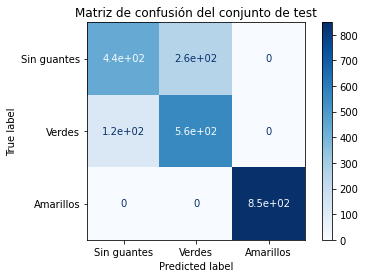

In [254]:
disp = plot_confusion_matrix(mejor_rfc4, X_test, y_test,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de test')

print('Matriz de confusión del conjunto de test')
print(disp.confusion_matrix)

Matriz de confusión del conjunto de entrenamiento
[[1047  551    0]
 [ 254 1410    0]
 [   0    0 1922]]


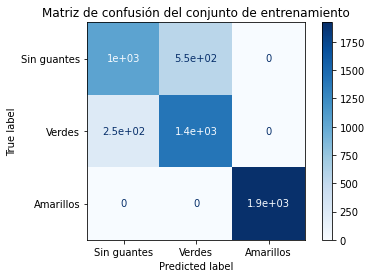

In [255]:
disp = plot_confusion_matrix(mejor_rfc4, X_train, y_train,
                                 display_labels=class_names2,
                                 cmap=plt.cm.Blues,
                            )
disp.ax_.set_title('Matriz de confusión del conjunto de entrenamiento')

print('Matriz de confusión del conjunto de entrenamiento')
print(disp.confusion_matrix)

In [256]:
#Reporte para el conjunto de test
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       695
           1       0.68      0.82      0.75       680
           2       1.00      1.00      1.00       848

    accuracy                           0.83      2223
   macro avg       0.82      0.82      0.81      2223
weighted avg       0.84      0.83      0.83      2223



In [257]:
#Reporte para el conjunto de entrenamiento
print(classification_report(y_train, y_train_best))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72      1598
           1       0.72      0.85      0.78      1664
           2       1.00      1.00      1.00      1922

    accuracy                           0.84      5184
   macro avg       0.84      0.83      0.83      5184
weighted avg       0.85      0.84      0.84      5184

